In [ ]:
# this is copied from (20.10)comp_tfidf_002

In [52]:
import warnings
warnings.simplefilter('ignore')
warnings.warn('deprecated',DeprecationWarning)

In [2]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score,confusion_matrix

In [5]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=True)

In [6]:
xcf_data=pd.read_csv('~/final_flavour/june_datasets/(14.09)xcf_flavordb_data.csv',index_col=0,converters={'flavordb_ingrs':eval})
ars_data=pd.read_csv('~/final_flavour/june_datasets/(23.09)ars_flavordb_data.csv',index_col=0,converters={'flavordb_ingrs':eval})
kb_data=pd.read_csv('~/final_flavour/june_datasets/(29.06)kb_flavordb_data.csv',index_col=0,converters={'flavordb_ingrs':eval})

In [7]:
print(xcf_data.shape)
print(ars_data.shape)
print(kb_data.shape)

(11821, 2)
(10623, 2)
(9047, 2)


In [8]:
xcf_data=xcf_data.explode('flavordb_ingrs').reset_index(drop=True)
ars_data=ars_data.explode('flavordb_ingrs').reset_index(drop=True)
kb_data=kb_data.explode('flavordb_ingrs').reset_index(drop=True)

In [9]:
allorigin_ingrs=pd.concat([xcf_data,ars_data,kb_data],axis=0).reset_index(drop=True)
allorigin_ingrs.shape

(237642, 2)

In [10]:
allorigin_ingrs.head()

,recipe_id,flavordb_ingrs
0,x_100000002,capsicum
1,x_100000002,lettuce
2,x_100000002,garlic
3,x_100000003,gelatin
4,x_100000003,yogurt


In [11]:
# load flavor compounds

In [14]:
ingr_comp=pd.read_csv('~/final_flavour/flavordb_datasets/(10.01)propossed_ingr_comp.csv',index_col=0)
ingr_comp.shape

(60263, 5)

In [15]:
ingr_comp.head()

,ingredient_id,ingredient_name,compound_id,compound_name,CAS_number
0,0,egg,182,Dimethyl disulfide,624-92-0
1,0,egg,1095,L-histidine,71-00-1@26062-48-6
2,0,egg,45,Isobutyraldehyde,78-84-2
3,0,egg,127,Styrene,9003-53-6@100-42-5@98444-30-5@68441-35-0@12770...
4,0,egg,510,1-Undecanol,30207-98-8@143819-62-9@112-42-5


In [16]:
allorigin_ingrs_list=list(set(allorigin_ingrs['flavordb_ingrs'].values.tolist()))
print(len(allorigin_ingrs_list))

467


In [17]:
# find ingredients with compounds

In [18]:
needed_ingr_comp=ingr_comp[ingr_comp['ingredient_name'].isin(allorigin_ingrs_list)]
needed_ingr_comp.shape

(39165, 5)

In [19]:
needed_ingr_comp=needed_ingr_comp[['ingredient_id','ingredient_name','compound_id']]

In [20]:
needed_ingr_comp.head()

,ingredient_id,ingredient_name,compound_id
0,0,egg,182
1,0,egg,1095
2,0,egg,45
3,0,egg,127
4,0,egg,510


In [21]:
# tranform the dataset to what we need

In [22]:
def ingr_matrix(form_data,col1,col2):
    ingr_dummy=pd.get_dummies(form_data[col1]).groupby(form_data[col2]).sum()
    return ingr_dummy
def comp_martix(ingr_comp,col1,col2):
    comp_dummy=pd.crosstab(ingr_comp[col1],ingr_comp[col2])
    return comp_dummy

In [23]:
ingr_dummy=ingr_matrix(allorigin_ingrs,'flavordb_ingrs','recipe_id')
ingr_dummy.shape

(31491, 467)

In [24]:
ingr_dummy.head()

,abalone,agar,agave,alaska_pollock,alfalfa,allspice,almond,amaranth,american_butterfish,anchovy,...,whisky,white_bread,white_wine,whitefish,wholewheat_bread,wine,wonton_wrapper,yam,yogurt,zwieback
recipe_id,,,,,,,,,,,,,,,,,,,,,
a_100070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a_100075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a_100083,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a_100096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a_100117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
comp_dummy=comp_martix(needed_ingr_comp,'ingredient_name','compound_id')
comp_dummy.shape

(467, 1591)

In [26]:
comp_dummy.head()

compound_id,1,2,3,4,5,6,7,8,9,10,...,1768,1769,1770,1771,1772,1773,1774,1775,1778,1779
ingredient_name,,,,,,,,,,,,,,,,,,,,,
abalone,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
agar,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
agave,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
alaska_pollock,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alfalfa,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [31]:
recipe_comp=ingr_dummy.dot(comp_dummy.values)
recipe_comp.shape

(31491, 1591)

In [32]:
recipe_comp.reset_index(inplace=True)

In [33]:
recipe_comp.head()

,recipe_id,0,1,2,3,4,5,6,7,8,...,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590
0,a_100070,9,9,9,9,10,9,9,9,9,...,0,0,0,0,0,0,0,0,0,0
1,a_100075,1,1,2,1,2,1,3,1,1,...,0,0,0,0,0,0,0,0,0,0
2,a_100083,2,2,4,3,3,2,4,3,2,...,0,0,0,0,0,0,0,0,0,0
3,a_100096,1,1,3,1,2,1,4,2,1,...,0,0,0,0,0,0,0,0,0,0
4,a_100117,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# add target value

In [34]:
for index,row in recipe_comp.iterrows():
    if re.search('a',row['recipe_id']):
        recipe_comp.loc[index,'origin']=1
    if re.search('k',row['recipe_id']):
        recipe_comp.loc[index,'origin']=2
    if re.search('x',row['recipe_id']):
        recipe_comp.loc[index,'origin']=0

In [35]:
# split train and test set

In [36]:
recipe_comp.drop('recipe_id',axis=1,inplace=True)

In [37]:
train_df,test_df,train_y,test_y=train_test_split(recipe_comp.drop('origin',axis=1),recipe_comp['origin'],test_size=0.3)

In [38]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590
9199,2,2,4,3,3,2,4,2,2,2,...,0,0,0,0,0,0,0,0,0,0
26779,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22598,2,2,2,2,3,2,3,2,2,2,...,0,0,0,0,0,0,0,0,0,0
22660,0,0,2,0,0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24357,5,6,5,5,5,5,5,5,5,6,...,0,0,0,0,0,0,0,0,0,0


In [39]:
train_X=train_df.values
test_X=test_df.values

In [40]:
# use tf-idf transformer

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(smooth_idf=True)

In [42]:
train_X=tfidf_transformer.fit_transform(train_X).toarray()
test_X=tfidf_transformer.transform(test_X).toarray()

In [43]:
# NB
def NB_pipeline(train_X,test_X,train_y,test_y):
    nb = MultinomialNB()
    cv=ShuffleSplit(n_splits=10,test_size=0.3,random_state=9527)
    nb_cv_results=cross_val_score(nb,train_X,train_y,cv=cv)
    nb.fit(train_X,train_y)
    y_pred=nb.predict(test_X)
    print('Mean Accuracy: %0.2f (+/- %0.2f)' % (nb_cv_results.mean(), nb_cv_results.std() * 2))
    print('Accuracy on test set: %0.2f' % accuracy_score(y_pred,test_y))
    return y_pred

In [44]:
# logistic regression
def log_pipeline(train_X,test_X,train_y,test_y):
    clf=LogisticRegression(multi_class='multinomial',random_state=9527)
    param_distribs={'C':[0.1,1,10,100,1000],
                    'solver':['lbfgs','saga']}
    log_search=RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    log_search.fit(train_X,train_y)
    print('Best parameters:',log_search.best_params_)
    print('Best estimatro:',log_search.best_estimator_)
    print('Best score:',log_search.best_score_)
    log=log_search.best_estimator_
    y_pred=log.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [45]:
# random forest
def rf_pipeline(train_X,test_X,train_y,test_y):
    clf=RandomForestClassifier(random_state=42)
    param_distribs={'n_estimators':[int(x) for x in np.linspace(start = 300, stop = 500, num = 10)],
                    'max_features':['auto','sqrt','log2'],
                    'max_depth':[5,6,7,8,9,10],
                    'criterion':['gini','entropy']}
    random_search = RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    random_search.fit(train_X,train_y)
    print('Best parameters:',random_search.best_params_)
    print('Best estimatro:',random_search.best_estimator_)
    print('Best score:',random_search.best_score_)
    rf=random_search.best_estimator_
    rf.fit(train_X,train_y)
    y_pred=rf.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [46]:
# Learning curve
def plot_cv_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

In [47]:
nby_pred=NB_pipeline(train_X,test_X,train_y,test_y)

Mean Accuracy: 0.64 (+/- 0.02)
Accuracy on test set: 0.65


In [51]:
start_time=time.time()
logy_pred=log_pipeline(train_X,test_X,train_y,test_y)
print(time.time()-start_time)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters: {'solver': 'saga', 'C': 1000}
Best estimatro: LogisticRegression(C=1000, multi_class='multinomial', random_state=9527,
                   solver='saga')
Best score: 0.7678627469221305
accuracy score:  0.7692633361558001
214.7440948486328


In [53]:
rfy_pred=rf_pipeline(train_X,test_X,train_y,test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
Best estimatro: RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)
Best score: 0.7409152887654727
accuracy score:  0.7375105842506351


In [ ]:
# learning curve

In [54]:
# Learning curve
def plot_cv_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

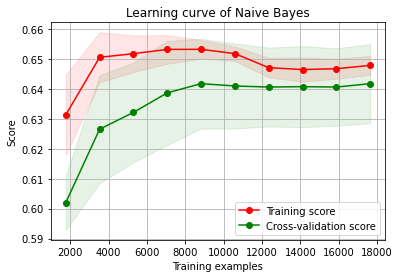

In [55]:
estimator=MultinomialNB()
plot_cv_learning_curve(estimator, 'Learning curve of Naive Bayes', train_X, train_y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/comp_tfidf_nb_lc.pdf',dpi=300, bbox_inches='tight')
plt.savefig('fig/png/comp_tfidf_nb_lc.png',dpi=300, bbox_inches='tight')

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

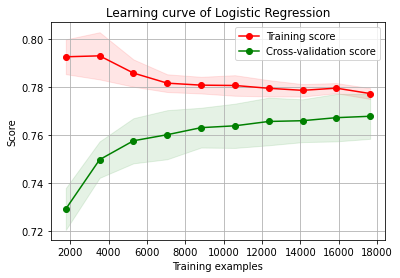

In [56]:
estimator=LogisticRegression(C=1000, multi_class='multinomial', random_state=9527,
                   solver='saga')
plot_cv_learning_curve(estimator, 'Learning curve of Logistic Regression', train_X, train_y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/comp_tfidf_log_lc.pdf',dpi=300, bbox_inches='tight')
plt.savefig('fig/png/comp_tfidf_log_lc.png',dpi=300, bbox_inches='tight')

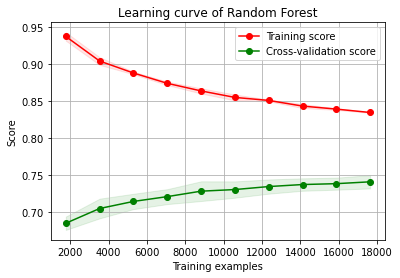

In [57]:
estimator=RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)
plot_cv_learning_curve(estimator, 'Learning curve of Random Forest', train_X, train_y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/comp_tfidf_rf_lc.pdf',dpi=300, bbox_inches='tight')
plt.savefig('fig/png/comp_tfidf_rf_lc.png',dpi=300, bbox_inches='tight')

In [ ]:
# confusion matrix

In [58]:
def plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=14)

    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.tight_layout()

In [59]:
log_cm=confusion_matrix(logy_pred,test_y)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.81 0.11 0.08]
 [0.09 0.75 0.16]
 [0.08 0.19 0.72]]


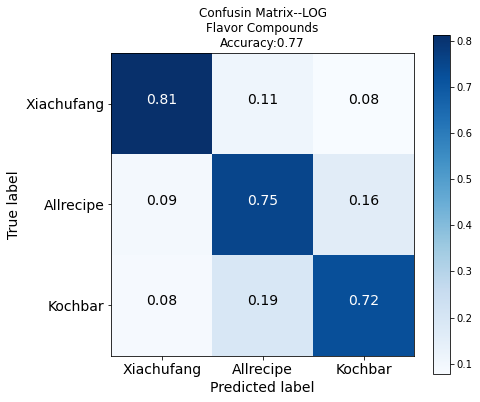

In [60]:
plt.figure(figsize=(7,6))
plot_confusion_matrix(log_cm,normalize=True,classes=['Xiachufang','Allrecipe','Kochbar'],
                      title='Confusin Matrix--LOG\nFlavor Compounds\nAccuracy:{0:.2f}'.format(accuracy_score(test_y,logy_pred)))
plt.savefig('fig/pdf/comp_tfidf_log_cm.pdf',dpi=300,bbox_inches='tight')
plt.savefig('fig/png/comp_tfidf_log_cm.png',dpi=300,bbox_inches='tight')